# PSU DS 200 

# Lab 7 Model Parameters Tuning and Overfitting Risk Reduction

## Instructor: Dr. John Yen
## TA: Rupesh Prajapati
## LA: Nathan Tack

## Total 6 Exercises:
- Exercise 1: 5 points
- Exercise 2: 5 points
- Exercise 3: 5 points
- Exercise 4: 5 points
- Exercise 5: 10 points
- Exercise 6: 20 points

## Total 50 points

## Due: 5 pm, October 12 (Monday)

## Learning Objectives

In this lab, we will learn the following:
- Save the pre-processed data file so that pre-processing steps can be saved in the future.
- Change the hyper parameter max_depth (i.e., the maximum depth of decision trees) for decision trees systematically and evaluate the trees created using f1 measure.
- Assess the overfitting risk of different models by comparing the f1 measure of training data vs f1 measure of testing data for different values of the hyper parameter max_depth.
- Identify the best value for max_depth parameter based on f1 scores.

## Acknowledgement: 
This lab uses datascience Python module developed at UC Berkeley.



In [1]:
import datascience
import numpy as np
import graphviz
import pandas as pd

from datascience import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 
from pandas import *
from numpy import *

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:17: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.6/dist-packages/datascience/util.py:10: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


# Exercise 1 Load the Breast Cancer Data File (5 points)

Complete the following code to use Table.read_table to load the breast cancer diagnosis data set from DS200Labs folder of your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls /content/drive/My\ Drive/DS200Labs/

BC_10_2					  faithful.csv
BC_10_2.pdf				  IMDB5000movies.csv
Ben-NE-9-10-2015-pass-6.csv		  player_data.csv
Ben_Pass_5_2				  salary_data.csv
Ben_Pass_5_2.pdf			  SFSalaries2011_2014.csv
breast-cancer-wisconsin-data-windCSV.csv  Tweets
BreatCancerFinal.csv


In [4]:
path= "/content/drive/My Drive/DS200Labs/breast-cancer-wisconsin-data-windCSV.csv"
BC_table = Table.read_table(path)
BC_table.show(5)

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
842517,M,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902
84300903,M,19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
84358402,M,20.29,14.34,135.1,1297,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575,0.1374,0.205,0.4,0.1625,0.2364,0.07678


In [5]:
BC_B_table = BC_table.where("diagnosis", are.equal_to("B"))
BC_B_table.show(5)

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
8510426,B,13.54,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,0.05766,0.2699,0.7886,2.058,23.56,0.008462,0.0146,0.02387,0.01315,0.0198,0.0023,15.11,19.26,99.7,711.2,0.144,0.1773,0.239,0.1288,0.2977,0.07259
8510653,B,13.08,15.71,85.63,520,0.1075,0.127,0.04568,0.0311,0.1967,0.06811,0.1852,0.7477,1.383,14.67,0.004097,0.01898,0.01698,0.00649,0.01678,0.002425,14.5,20.49,96.09,630.5,0.1312,0.2776,0.189,0.07283,0.3184,0.08183
8510824,B,9.504,12.44,60.34,273.9,0.1024,0.06492,0.02956,0.02076,0.1815,0.06905,0.2773,0.9768,1.909,15.7,0.009606,0.01432,0.01985,0.01421,0.02027,0.002968,10.23,15.66,65.13,314.9,0.1324,0.1148,0.08867,0.06227,0.245,0.07773
854941,B,13.03,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,0.05863,0.1839,2.342,1.17,14.16,0.004352,0.004899,0.01343,0.01164,0.02671,0.001777,13.3,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169
85713702,B,8.196,16.84,51.71,201.9,0.086,0.05943,0.01588,0.005917,0.1769,0.06503,0.1563,0.9567,1.094,8.205,0.008968,0.01646,0.01588,0.005917,0.02574,0.002582,8.964,21.96,57.26,242.2,0.1297,0.1357,0.0688,0.02564,0.3105,0.07409


In [6]:
BC_M_table = BC_table.where("diagnosis", are.equal_to("M"))
BC_M_table.show(2)

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
842517,M,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902


In [7]:
BC_B_table_zero = BC_B_table.with_column("classification", 0)
BC_M_table_one = BC_M_table.with_column("classification", 1)
BC_B_table_zero.show(2)
BC_M_table_one.show(2)

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,classification
8510426,B,13.54,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,0.05766,0.2699,0.7886,2.058,23.56,0.008462,0.0146,0.02387,0.01315,0.0198,0.0023,15.11,19.26,99.7,711.2,0.144,0.1773,0.239,0.1288,0.2977,0.07259,0
8510653,B,13.08,15.71,85.63,520,0.1075,0.127,0.04568,0.0311,0.1967,0.06811,0.1852,0.7477,1.383,14.67,0.004097,0.01898,0.01698,0.00649,0.01678,0.002425,14.5,20.49,96.09,630.5,0.1312,0.2776,0.189,0.07283,0.3184,0.08183,0


id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,classification
842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,1
842517,M,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902,1


In [8]:
BC_table_merged = BC_M_table_one.append(BC_B_table_zero)
BC_table_merged.show(2)

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,classification
842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,1
842517,M,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902,1


In [9]:
BC_table_final = BC_table_merged.drop("id", "diagnosis")
BC_table_final.show(2)

radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,classification
17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,1
20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902,1


In [10]:
BC_feature_names= BC_table_final.labels
print(BC_feature_names)
BC_table_final.num_columns

('radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'classification')


31

In [11]:
# Because the last column is 'classification', which is NOT a feture, but the model's prediction variable, therefore we need to extract the first 30 columns as the list of feature names.
BC_feature_names = BC_feature_names[0:30]
print(BC_feature_names)

('radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst')


# Exercise 2 (5 points)

Complete the path below to save this table as a CSV file named "BreastCancerFinal.csv" in the DS200Labs folder of you Google Drive so that we can use it later without going through all of the steps above. The datascience Python module provides a method "to_csv" to save a Table as a CSV file.

In [12]:
path2 = "/content/drive/My Drive/DS200Labs/BreatCancerFinal.csv"
BC_table_final.to_csv(path2)

In [13]:
!ls /content/drive/My\ Drive/DS200Labs/

BC_10_2					  faithful.csv
BC_10_2.pdf				  IMDB5000movies.csv
Ben-NE-9-10-2015-pass-6.csv		  player_data.csv
Ben_Pass_5_2				  salary_data.csv
Ben_Pass_5_2.pdf			  SFSalaries2011_2014.csv
breast-cancer-wisconsin-data-windCSV.csv  Tweets
BreatCancerFinal.csv


## Convert Tables to Data Frame
Like Lab 6, we first convert the final Breast Cancer dataset table to a DataFrame.

In [14]:
# Convert the Breast Cancer Final Table to a Data Frame using .to_df method of Tables in datascience module.
BC_DF= BC_table_final.to_df()

In [15]:
BC_features = BC_DF.values[:, 0:30]
print(BC_features)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.405e+01 2.715e+01 9.138e+01 ... 1.048e-01 2.250e-01 8.321e-02]
 [1.120e+01 2.937e+01 7.067e+01 ... 0.000e+00 1.566e-01 5.905e-02]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


In [16]:
BC_classification = BC_DF.values[:, 30]
print(BC_classification)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

# Exercise 3 (5 points)

Split the Breast Cancer dataset into a training set and a testing set using train_test_split. Choose the test_size parameter to be a number between 0.1 and 0.25. Like Lab 6, random_state is an integer for randomly splitting the data into two groups: one for training, the other for testing.

In [17]:
# Split the Labelled Data into Training Data and Testing Data
BC_f_train, BC_f_test, BC_out_train, BC_out_test = train_test_split(BC_features, BC_classification, test_size=0.2, random_state =200)

## Iterate/Looping in Python

In order to construct a decision tree using multiple values for the parameter max_depth, 
we will use "for loop" in Python to iterate over different possible values for the max_depth
parameter.

To iterate over a range of integer (say from 2 to 20), we can use the following code in Python:
```
    for d in range(2, 21):
        print(d)
```
The variable "d" is initially set to the minimum value of the range (i.e., 2 in the example
above).  After executing the body of the "for loop" once, the variable "d" is incrased by 1
(i.e., becomes 3), then it executes the body of the "for loop" for the second time. These two 
steps (i.e., executing the body of the for loop, increase the value of "d" by 1) iterate until
the value of the variable "d" reaches the maximum number of the range (i.e., 21 in the example
above). When the variable of the loop (i.e., "d" in this example) reaches the maximum number (i.e., 21 in this case), the loop terminates.

### Learning Tips: 
- The ':' at the end of "for" statement is important, because it indicates the next indented line is the beginning of the for loop.
- The body of the for loop (i.e., 'print(d)' in this example) is indented to the right.
- If the boody of the for loop includes additional steps (beyond printing the variable d), these steps will also be indented. 
    


# Exercise 4 Iteration (5 points)
Complete the code below by entering the minimum value and the maximum value in 
```
range(?min, ?max)
```
for the loop below. Make sure that they are both integers and the 
maximum value is higher than the minimum value. Execute the for loop and answer the following two questions:
- (1) What is the value of d in the last iteration?
- (2) What is the relationship between the maximum value and the value of d in the last iteration?

In [18]:
for d in range(4, 15): 
    print (d)

4
5
6
7
8
9
10
11
12
13
14


### Answer to Exercise 4: 
- (1)The value of d is 14.
- (2)maximum - 1

# Exercise 5 (10 points)
Choose a ragne of max_depth to generate and evaluate the decision tree for each max_depth using both training data and testing data.
- Choose the value of the low_max_depth and high_max_depth below, which determines the range of max_depth you will use to construct decision trees. Suggestion: Choose a value between 1 and 3.
- Execute the following code cells that generate the figure that shows the performance of f1 score for training data and testing data for each choice of max_depth. Suggestion: Choose a value between 10 and 20.

In [19]:
low_max_depth = 1
high_max_depth = 15
training_performance_table = np.empty( [high_max_depth+1, 4] )
testing_performance_table = np.empty( [high_max_depth+1, 4] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


# Four Important Variables
The following four variables, generated from train_test_split, are important to remember:
- *BC_f_train* : Breast Cancer features for training the predictive/diagnoistic model.
- *BC_out_train* : Breast Cancer classifications for training the predictive/diagnostic model.
- *BC_f_test* : Breast Cancer features reserved for testing the model.
- *BC_out_test* : Breast Cancer classification for evaluating the model (to be compared with the model prediction output).

In [20]:
# Prepare the word frequency matrix for the testing data, since it is 
# identical for every iteration of the for loop.

                                                
for depth in range(low_max_depth, high_max_depth+1):
    # Create the decision tree using a specific value for max_depth parameter
    clf = tree.DecisionTreeClassifier(criterion='entropy', random_state = 100, max_depth=depth, \
                                  min_samples_leaf =2)
    clf.fit(BC_f_train, BC_out_train)
    
    ### Use the model generated to predict for training data
    predicted_training_y = clf.predict(BC_f_train)
#   print("Max Depth is ", depth, "Prediction Performance for Training Data")
    train_p = metrics.precision_score(BC_out_train, predicted_training_y)
    train_r = metrics.recall_score(BC_out_train, predicted_training_y)
    train_f1 = metrics.f1_score(BC_out_train, predicted_training_y)
    training_performance_table[depth,0] = depth
    training_performance_table[depth,1] = train_p
    training_performance_table[depth,2]= train_r
    training_performance_table[depth,3]= train_f1
    
    ### Use the model generated to predict for testing data
    predicted_testing_y = clf.predict(BC_f_test)
#   print("Prediction Performance for Testing Data")
    test_p = metrics.precision_score(BC_out_test, predicted_testing_y)
    test_r = metrics.recall_score(BC_out_test, predicted_testing_y)
    test_f1 = metrics.f1_score(BC_out_test, predicted_testing_y)
    testing_performance_table[depth,0] = depth
    testing_performance_table[depth,1] = test_p
    testing_performance_table[depth,2] = test_r
    testing_performance_table[depth,3] = test_f1


# Visualizing the performance for different max_depth


In [21]:
print(training_performance_table[low_max_depth:high_max_depth,3])

[0.89944134 0.91052632 0.95072464 0.97126437 0.97701149 0.9915493
 0.99150142 0.99150142 0.99150142 0.99150142 0.99150142 0.99150142
 0.99150142 0.99150142]


In [22]:
print(testing_performance_table[low_max_depth:high_max_depth,3])

[0.87179487 0.86419753 0.92753623 0.91428571 0.92753623 0.88888889
 0.90140845 0.90140845 0.90140845 0.90140845 0.90140845 0.90140845
 0.90140845 0.90140845]


In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [24]:
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  """Entry point for launching an IPython kernel.


In [25]:
f1_training = training_performance_table[low_max_depth:high_max_depth+1, 3]
f1_testing = testing_performance_table[low_max_depth:high_max_depth+1, 3]
depth = np.linspace(low_max_depth, high_max_depth, high_max_depth-low_max_depth+1)
print(depth)
print(f1_training)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
[0.89944134 0.91052632 0.95072464 0.97126437 0.97701149 0.9915493
 0.99150142 0.99150142 0.99150142 0.99150142 0.99150142 0.99150142
 0.99150142 0.99150142 0.99150142]


# Exercise 6 (20 points, 5 points for each questions: 6-a, 6-b, 6-c, and 6-d)

Execute the code below to plot f1 measure for evaluating the decision trees with different max_depth.  The blue line shows the f1 measures of training data, and the red line shows the f1 measures of testing data.  Answer the following questions:
- (a) Describe how the performance (f1 measure) changes as the max_depth increases. 
- (b) Describe the difference between the f1 measure for training data and the f1 measure for testing data.
- (c) Should you use training data performance or testing data performance for selecting hyper parameters of the decision trees (e.g., max_depth)? Explain your rationale.
- (d) What value whould you choose for the max_depth of decision trees for the Breast Cancer diagnosis problem? Explain your rationale.

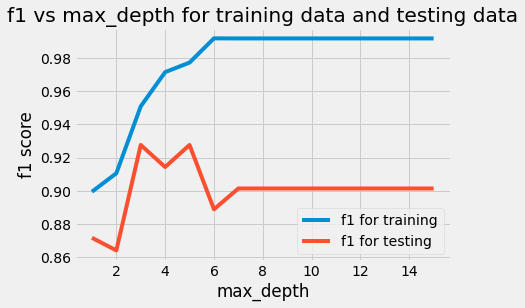

In [26]:
plt.plot(depth, f1_training, label="f1 for training")
plt.plot(depth, f1_testing, label="f1 for testing")
plt.xlabel('max_depth')
plt.ylabel('f1 score')
plt.title('f1 vs max_depth for training data and testing data')
plt.legend()
plt.show()

# Answer to Exercise 6
- (a)As the max depth increased, the f1 for training is also increased, after the max equal to some value, it becomes constant. The f1 for testing is decreasing from 1 to 2, 3 to 4 and 5 to 6, it's increasing from 2 to 3, 4 to 5 and 6 to 7, it's constant from 7 to 14.
- (b)The f1 for training data is always higher than f1 for testing data. At some points, the f1 for testing data will decrease, then the difference between training and testing data becomes larger. Sometimes it will also have smaller difference.
- (c)We should select the testing data performance, because testing data set spans the various classes that the model would face, while the training data has biases.
- (d)I will chosse 3 for the max depth, because it has smallest difference between training and testing performance.